#Bài toán xác định và làm mở biển số xe ở Việt Nam.


*   Bộ môn: Máy học - CS114.M21.KHCL
*   Giảng viên:
    *   Lê Đình Duy
    *   Phạm Nguyễn Trường An
*   Thành viên nhóm:
    *   Đào Trần Anh Tuấn
    *   Lê Trần Hữu Phước
    *   Trần Phú Vinh
* Nguồn tham khảo:
    * facebookresearch/detectron2
    * roboflowteam







# Install Detectron2 Dependencies

In [1]:
#Liên kết google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cài đặt packages cần thiết
# Cài đặt dependencies: (dùng cu101 vì colab sử dụng CUDA bản 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# Cài đặt detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [5]:
#Lấy bộ dữ liệu đã chuẩn bị sẵn từ Roboflow 
!curl -L "https://app.roboflow.com/ds/KdOneQPUgT?key=MOJChnvGDG" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   884  100   884    0     0     35      0  0:00:25  0:00:24  0:00:01   267
100  209M  100  209M    0     0  7381k      0  0:00:29  0:00:29 --:--:-- 57.0M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/BXMDTet_50940_jpg.rf.67abeafceddcde9d1042d7206ec8c3cc.jpg  
 extracting: test/BXMDTet_51150_jpg.rf.df28ac2063fb08dad8a02e679eb240b1.jpg  
 extracting: test/BXMDTet_51420_jpg.rf.2ec80dd36c8ccb0532a2b5b72eae7e67.jpg  
 extracting: test/BXMDTet_51690_jpg.rf.1a26308c0373c703d080ebc0d15e9a07.jpg  
 extracting: test/BXMDTet_51750_jpg.rf.dfea6b33fb9c8adc40ae703a5e6d8c15.jpg  
 extracting: test/BXMDTet_51990_jpg.rf.c270cf6931ee8b9cdc8ca836f163a516.jpg  
 extracting: test/BXMDbuoisang_11790_jpg.rf.b86bd0eb58a5c9e642f8a3bfd80818f5.jpg  
 extracting: te

In [6]:
# "Register" dữ liệu cho cả 3 tập train-val-test
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [07/11 14:13:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/11 14:13:46 d2.data.datasets.coco]: Loaded 2385 images in COCO format from /content/train/_annotations.coco.json


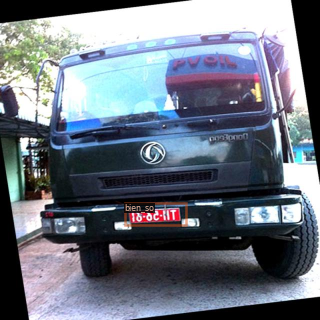

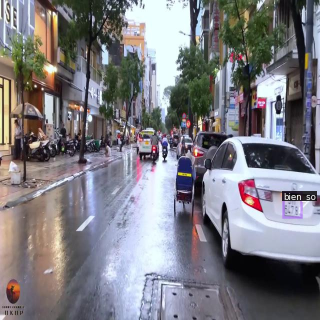

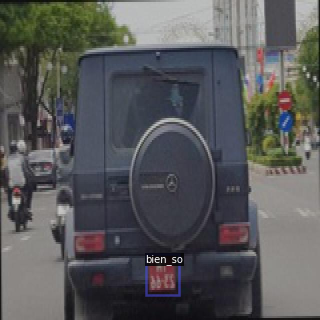

In [7]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [8]:
#Set up các thư viện cần thiết để tiến hành train mô hình trên tập dữ liệu. 

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [15]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 5700 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

# Use GPU to train
cfg.MODEL.DEVICE = 'cuda'



cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #your number of classes + 1

# Set the period test model
cfg.TEST.EVAL_PERIOD = 500

#set the output directory
cfg.OUTPUT_DIR = "/content/drive/MyDrive/detectron/output3"
# Save a checkpoint after every this number of iterations
cfg.SOLVER.CHECKPOINT_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[07/11 14:41:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (3, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (8, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (8,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[07/11 14:41:38 d2.engine.train_loop]: Starting training from iteration 5700
[07/11 14:41:38 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


In [16]:
#Đánh giá trên tập test 
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output3/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (3, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (8, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (8,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


WARNING [07/11 14:41:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/11 14:41:49 d2.data.datasets.coco]: Loaded 347 images in COCO format from /content/test/_annotations.coco.json
[07/11 14:41:49 d2.data.common]: Serializing 347 elements to byte tensors and concatenating them all ...
[07/11 14:41:49 d2.data.common]: Serialized dataset takes 0.10 MiB
[07/11 14:41:49 d2.evaluation.evaluator]: Start inference on 347 images
[07/11 14:41:51 d2.evaluation.evaluator]: Inference done 11/347. 0.1866 s / img. ETA=0:01:03
[07/11 14:41:56 d2.evaluation.evaluator]: Inference done 38/347. 0.1872 s / img. ETA=0:00:58
[07/11 14:42:02 d2.evaluation.evaluator]: Inference done 65/347. 0.1881 s / img. ETA=0:00:53
[07/11 14:42:07 d2.evaluation.evaluator]: Inference done 92/347. 0.1888 s / img. ETA=0:00:48
[07/11 14:42:12 d2.evaluation.evaluator]: Inference done 118/347. 0.1894 s / img. ETA=0:00:43
[07/11 14:42:17 d2.evaluation.evaluat

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP-bien_so': 0.0,
               'AP-license-plate': nan,
               'AP50': 0.0,
               'AP75': 0.0,
               'APl': 0.0,
               'APm': 0.0,
               'APs': 0.0})])

# Inference with Detectron2 Saved Weights



In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (3, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (8, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (8,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


#Detect on image

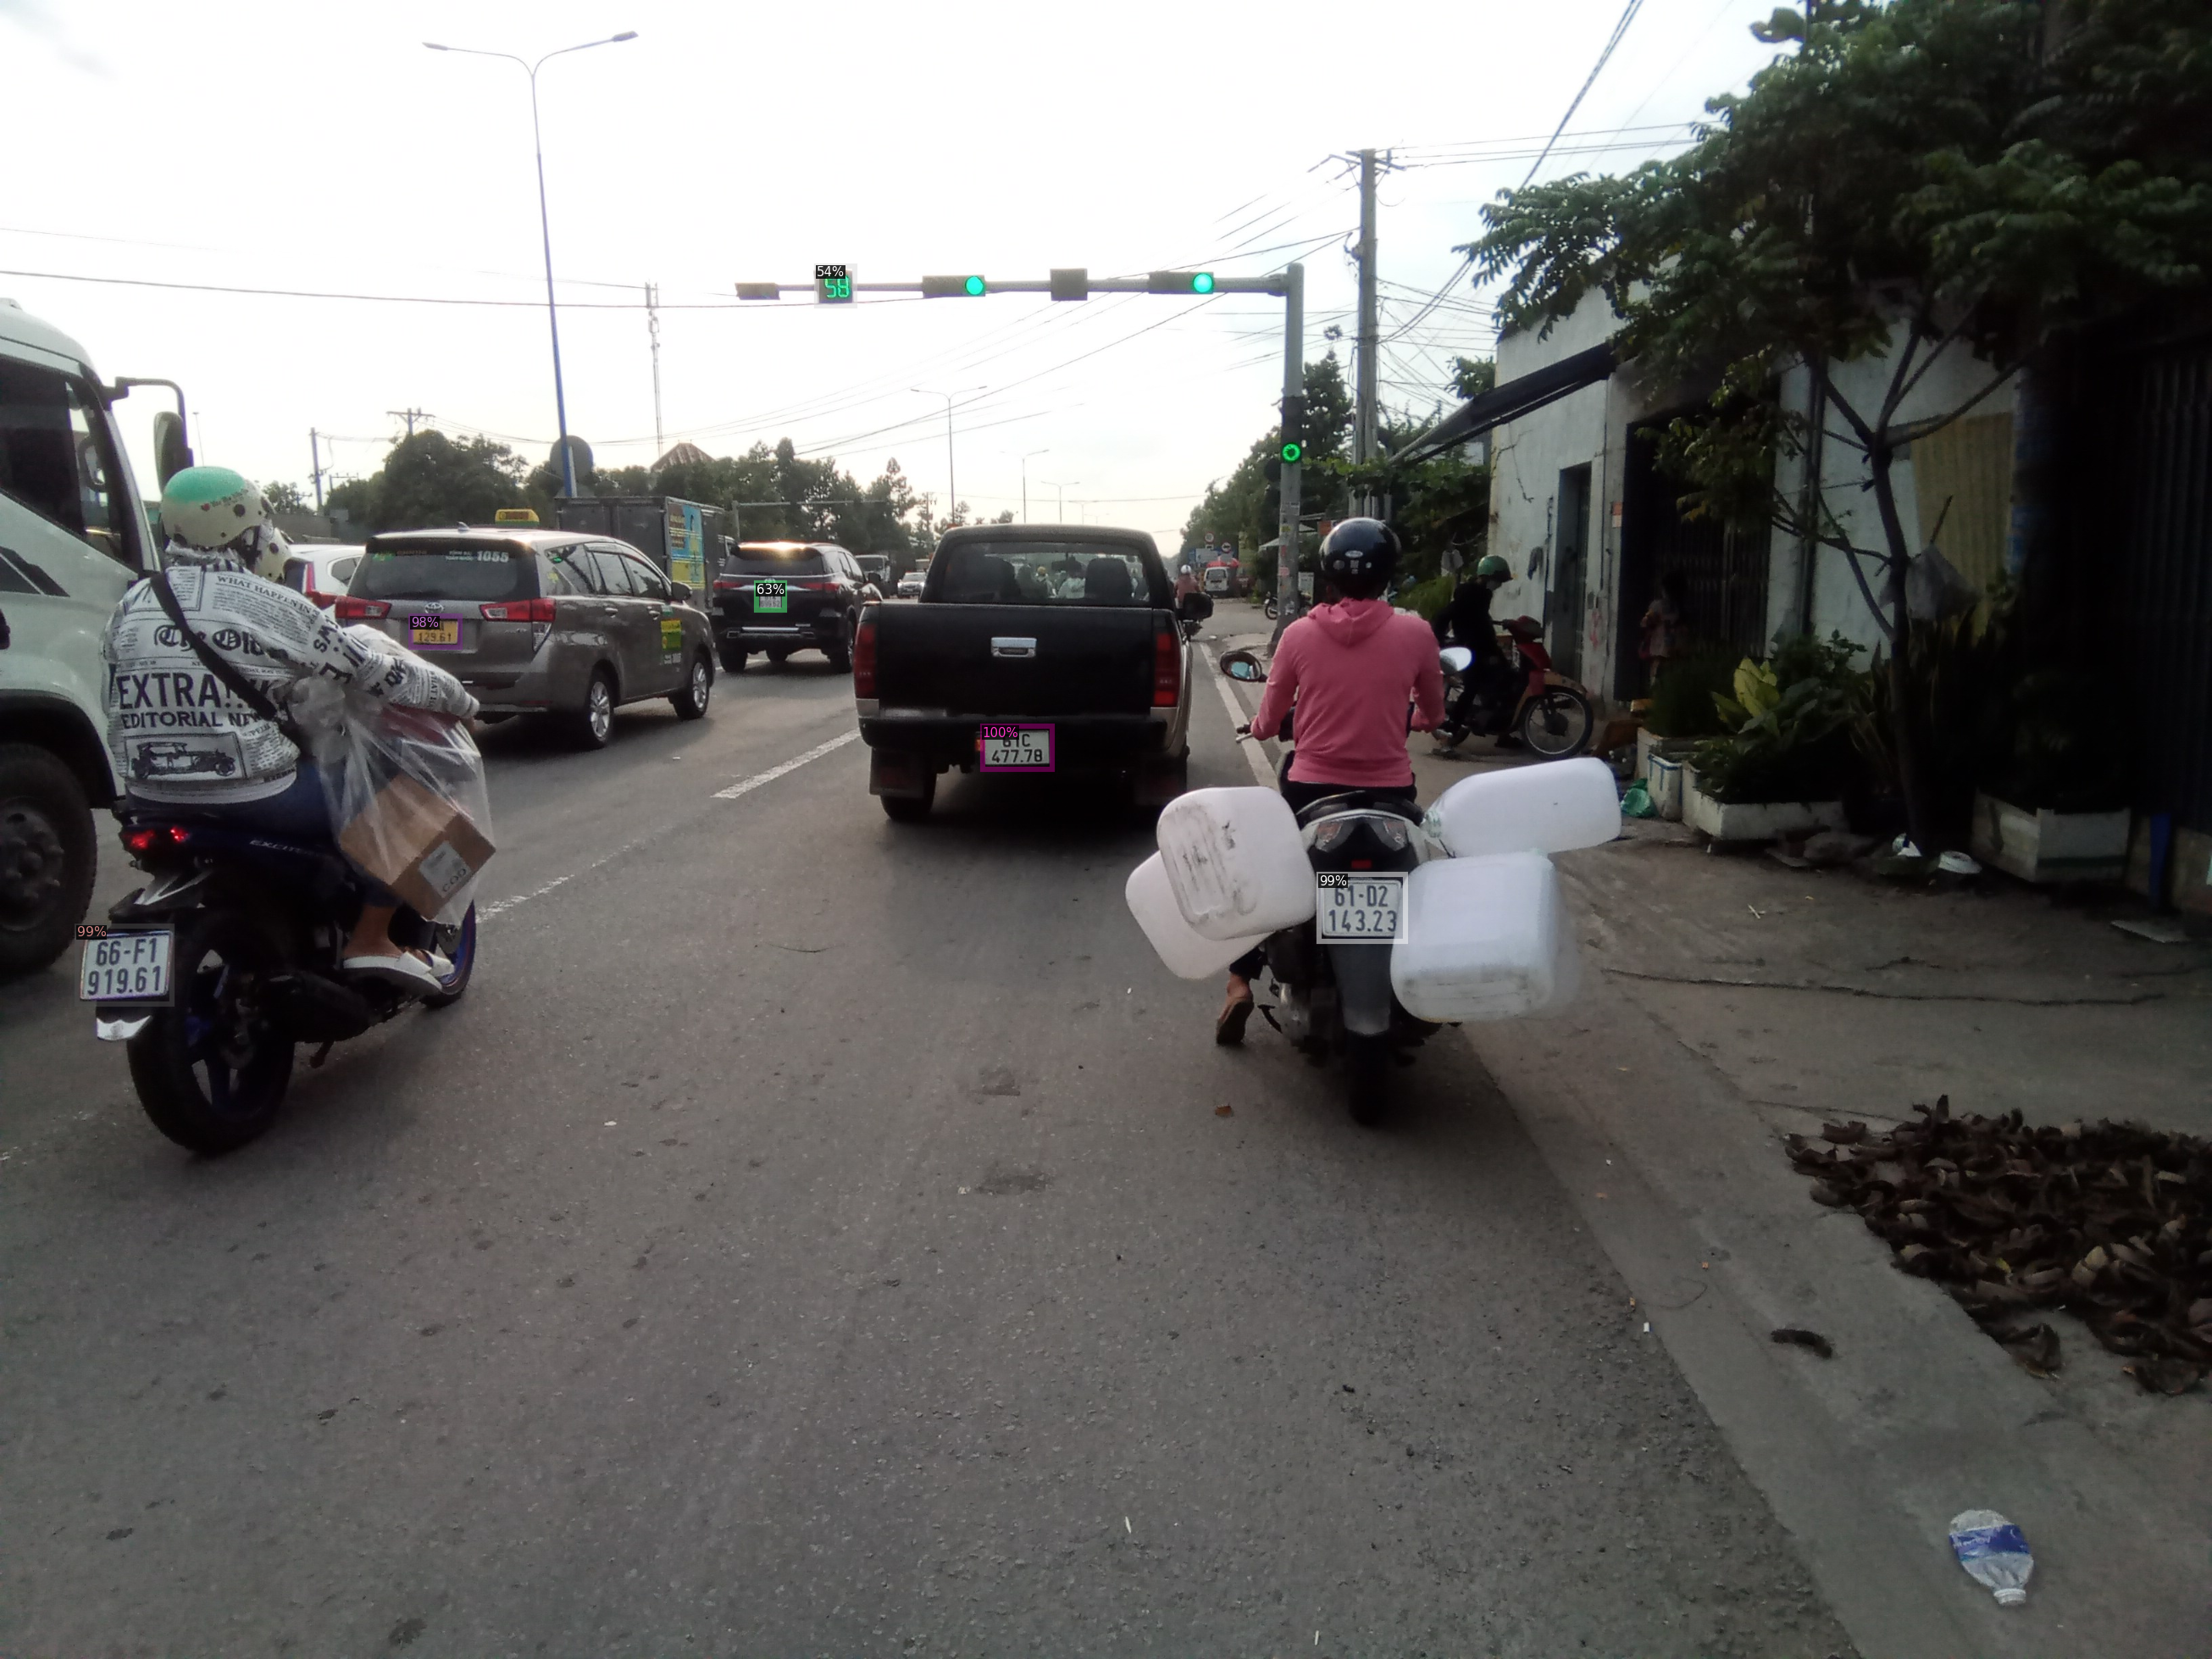

In [ ]:
#Detect trên ảnh 
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
# Get the training dataset
cfg.DATASETS.TRAIN = ("dataset_train",)

# Use GPU to train
cfg.MODEL.DEVICE = 'cuda'

# Number of classes + 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 

# Output dir to load model
cfg.OUTPUT_DIR = "/content/drive/MyDrive/detectron/output3"

# Load weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Set thresh
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25   # set the testing threshold for this model



predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("/content/train/_annotations.coco.json")


# Read image and detect
im = cv2.imread('/content/drive/MyDrive/DatasetCS114/test/IMG_20220609_162144_233.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
            metadata=test_metadata, 
            scale=0.8
                )

# Draw bounding box and plot image
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

#Detect on Video


In [19]:
#Detect trên video
%cd /content/
!git clone https://github.com/facebookresearch/detectron2

/content
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [13]:
#"Đăng ký" datasets cho video trong tập test cần được detect
%cd /content/drive/MyDrive/detectron/detectron2/detectron2
register_coco_instances("dataset_test12", {}, "/content/train/_annotations.coco.json", "/content/drive/MyDrive/detectron/testing_Trim.mp4")


/content/drive/MyDrive/detectron/detectron2/detectron2


In [21]:
%cd /content/drive/MyDrive/detectron/detectron2/detectron2
%run demo/demo.py --config-file /content/drive/MyDrive/detectron/detectron2/detectron2/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml --video-input /content/drive/MyDrive/detectron/testing_Trim.mp4 --confidence-threshold 0.6 --output /content/drive/MyDrive/video.mkv --opts MODEL.WEIGHTS /content/drive/MyDrive/detectron/output3/model_final.pth


/content/drive/MyDrive/detectron/detectron2/detectron2
[07/11 14:59:59 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='/content/drive/MyDrive/detectron/detectron2/detectron2/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml', input=None, opts=['MODEL.WEIGHTS', '/content/drive/MyDrive/detectron/output3/model_final.pth'], output='/content/drive/MyDrive/video.mkv', video_input='/content/drive/MyDrive/detectron/testing_Trim.mp4', webcam=False)
[07/11 15:00:00 fvcore.common.checkpoint]: [Checkpointer] Loading from /content/drive/MyDrive/detectron/output3/model_final.pth ...
WARNING [07/11 15:00:02 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (3, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
WARNING [07/11 15:00:02 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the m

100%|██████████| 736/736 [06:36<00:00,  1.86it/s]
